In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display

# set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(42)

### Import the mini Speech Commands dataset

In [4]:
DATASET_PATH = "data/mini_speech_commands"

data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():
  tf.keras.utils.get_file(
		"mini_speech_commands.zip",
		origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
		extract=True,
		cache_dir=".", cache_subdir="data"
	)

# The dataset"s audio clips are stored in eight folders corresponding to each speech command:
# 	no, yes, down, go, left, up, right, and stop
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

commands = commands[commands != "README.md"]

print("Commands:", commands)

# Extract the audio clips into a list called filenames, and shuffle it:
filenames = tf.io.gfile.glob(str(data_dir) + "/*/*")
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print("Number of total examples:", num_samples)
print("Number of examples per label:", len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print("Example file tensor:", filenames[0])

# Split filenames into training, validation and test sets using a 80:10:10 ratio, respectively:
train_files = filenames[:6400] # First 6400
val_files = filenames[6400: 6400 + 800] # Next 800
test_files = filenames[-800:] # Last 800

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Commands: ['left' 'down' 'up' 'stop' 'yes' 'no' 'right' 'go']
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/no/96ab6565_nohash_0.wav', shape=(), dtype=string)
Training set size 6400
Validation set size 800
Test set size 800


2022-06-18 15:39:25.159416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 15:39:25.289027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 15:39:25.289490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 15:39:25.300998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Read the audio files and their labels

In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

1. Each WAV file contains time-series data with a set number of samples per second.
2. Each sample represents the amplitude of the audio signal at that specific time.
3. In a 16-bit system, like the WAV files in the mini Speech Commands dataset, the amplitude values range from -32,768 to 32,767.
4. The sample rate for this dataset is 16kHz.

The shape of the tensor returned by tf.audio.decode_wav is [samples, channels], where channels is 1 for mono or 2 for stereo. The mini Speech Commands dataset only contains mono recordings. 

In [5]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

Preprocess the dataset's raw WAV audio files into audio tensors

In [6]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Function that creates labels using the parent directories for each file

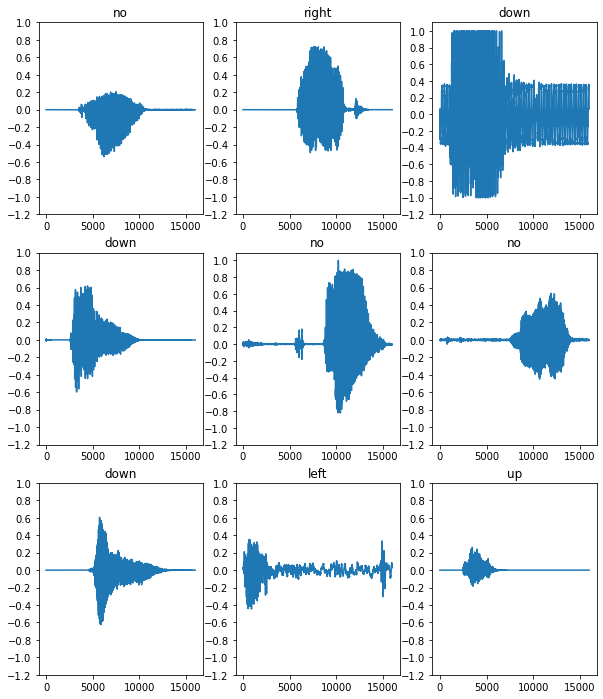

In [8]:
def get_label(file_path):
  parts = tf.strings.split(
    input=file_path,
    sep=os.path.sep
  )
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
  map_func=get_waveform_and_label,
  num_parallel_calls=tf.data.AUTOTUNE
)

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

### Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:
- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using tf.zeros).
- When calling tf.signal.stft, choose the frame_length and frame_step parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to this Coursera video on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying tf.abs on the output of tf.signal.stft.


In [14]:
def get_spectrogram_from_waveform(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [25]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram_from_waveform(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Function to display a spectogram

In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

print()

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

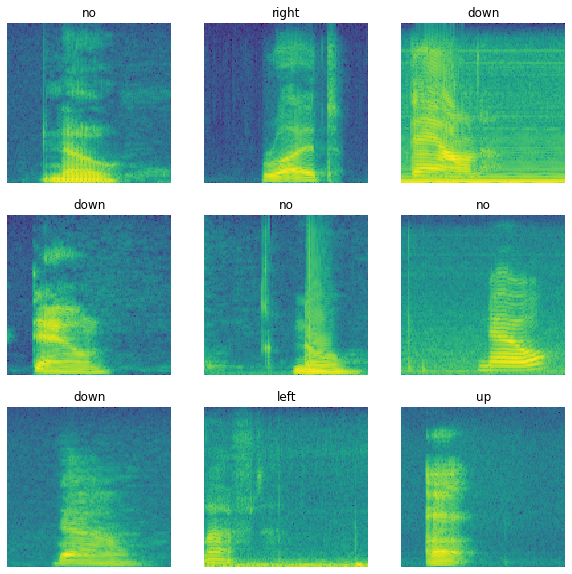

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram_from_waveform(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE
)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

### Build and train the model

In [29]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)

  output_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE
  )

  output_ds = output_ds.map(
    map_func=get_spectrogram_and_label_id,
    num_parallel_calls=AUTOTUNE
  )

  return output_ds

In [30]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [31]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model

In [32]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your tf.keras.Sequential model will use the following Keras preprocessing layers:

- tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
- tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.

For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [43]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram[0].shape

print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=input_shape),
  # Downsample the input.
  tf.keras.layers.Resizing(32, 32),
  # Normalize.
  norm_layer,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

Epoch 1/20
100/100 [==============================] - 1s 8ms/step - loss: 1.7208 - accuracy: 0.3770 - val_loss: 1.3573 - val_accuracy: 0.5412
Epoch 2/20
100/100 [==============================] - 1s 6ms/step - loss: 1.1954 - accuracy: 0.5736 - val_loss: 0.9952 - val_accuracy: 0.6888
Epoch 3/20
100/100 [==============================] - 1s 6ms/step - loss: 0.9160 - accuracy: 0.6778 - val_loss: 0.7632 - val_accuracy: 0.7613
Epoch 4/20
100/100 [==============================] - 1s 6ms/step - loss: 0.7431 - accuracy: 0.7381 - val_loss: 0.7150 - val_accuracy: 0.7800
Epoch 5/20
100/100 [==============================] - 1s 6ms/step - loss: 0.6026 - accuracy: 0.7945 - val_loss: 0.6372 - val_accuracy: 0.8050
Epoch 6/20
100/100 [==============================] - 1s 6ms/step - loss: 0.5504 - accuracy: 0.8019 - val_loss: 0.6027 - val_accuracy: 0.8200
Epoch 7/20
100/100 [==============================] - 1s 6ms/step - loss: 0.4804 - accuracy: 0.8298 - val_loss: 0.5844 - val_accuracy: 0.8163
Epoch 

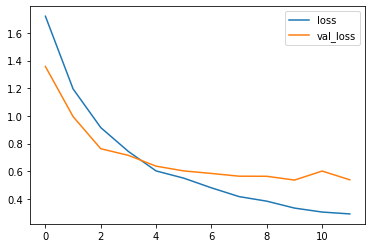

In [44]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],
)

EPOCHS = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

metrics = history.history

plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### Evaluate the model performance

In [38]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 0s 3ms/step
Test set accuracy: 82%


#### Display a confusion matrix

In [39]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))

sns.heatmap(
  confusion_mtx,
  xticklabels=commands,
  yticklabels=commands,
  annot=True,
  fmt='g'
)

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Run inference on an audio file
Verify the model's prediction output using an input audio file of someone saying "no"

Predictions:
left: 0.0009
down: 0.0193
up: 0.0008
stop: 0.0003
yes: 0.0003
no: 0.8324
right: 0.0006
go: 0.1454


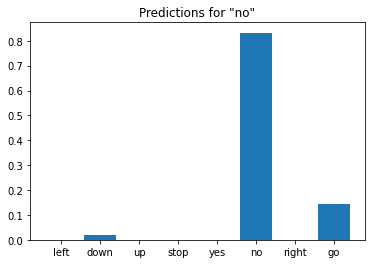

In [52]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  predictions = model(spectrogram)

  print("Predictions:")
  for pred_val, command in zip(tf.nn.softmax(predictions[0]), commands):
    print(f"{command}: {pred_val:.4f}")

  plt.bar(commands, tf.nn.softmax(predictions[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()